In [1]:
# Disable TOKENIZERS_PARALLELISM for better compatibility
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: masrur. Use `wandb login --relogin` to force relogin


True

In [2]:
# Import necessary libraries
import datasets
from datasets import load_dataset
import evaluate
import torch.nn.functional as F
import torch.nn as nn

# Import features for dataset processing
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# Import Transformer libraries
from transformers import AutoModel, LayoutLMv3Processor

# Import PyTorch Lightning for training
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

# Import PyTorch components for optimization
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader

# Import tqdm for progress visualization
from tqdm.auto import tqdm

# Import torchvision for image processing
from torchvision.transforms import ToPILImage


/home/glad_admin/anaconda3/envs/docai/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download and explore the dataset


Reusing dataset funsd (/home/glad_admin/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9)
100%|██████████| 2/2 [00:00<00:00, 1268.31it/s]


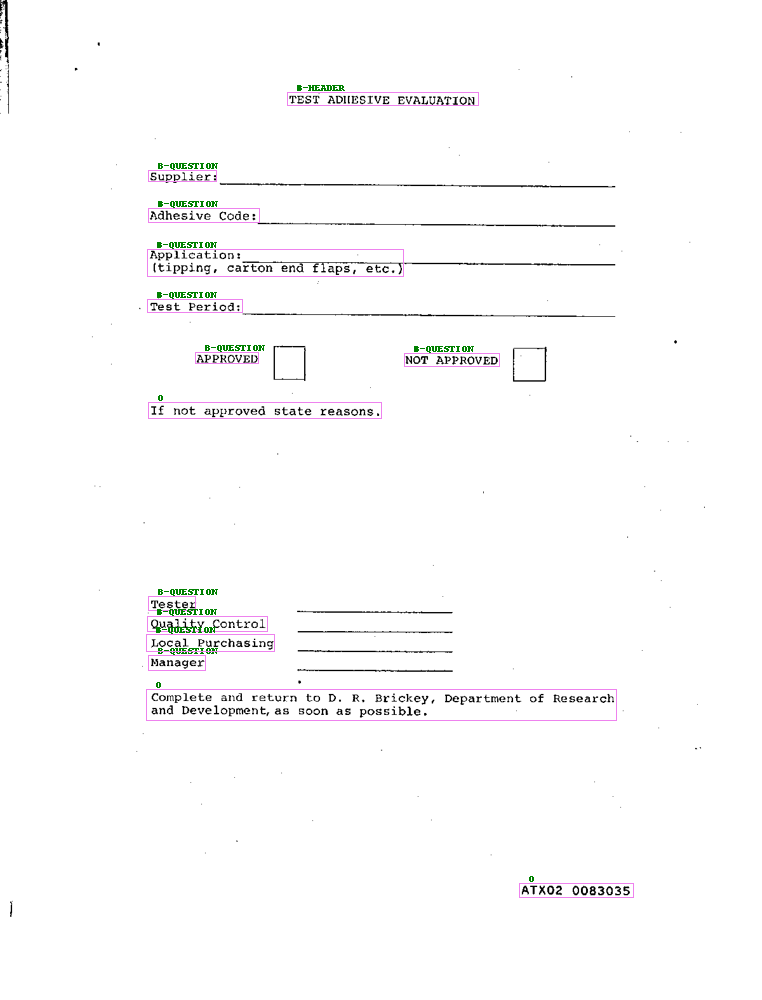

In [3]:
# Loading the Funsd LayoutLMv3 dataset
dataset = load_dataset("nielsr/funsd-layoutlmv3")


# Visualizing bounding boxes function
def plot_visualization(sample: dict):
    """
    Plots bounding boxes and labels on the image.

    Args:
        sample (dict): A dictionary containing image, bounding boxes, and ner_tags.

    Returns:
        Image: An annotated image with visualized bounding boxes and labels.
    """

    # Importing necessary libraries
    from PIL import ImageDraw, ImageFont

    img = sample["image"]
    bbox = sample["bboxes"]
    ner_tags = sample["ner_tags"]

    # Creating drawing object and font
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()

    for box, predicted_label in zip(bbox, ner_tags):
        # Rescaling bounding box coordinates to match the image size
        box[0] = int(img.size[0] * box[0] / 1000)
        box[1] = int(img.size[1] * box[1] / 1000)
        box[2] = int(img.size[0] * box[2] / 1000)
        box[3] = int(img.size[1] * box[3] / 1000)

        # Drawing rectangle and label on the image
        draw.rectangle(box, outline="violet")
        draw.text(
            (box[0] + 10, box[1] - 10),
            text=labels[predicted_label],
            fill="green",
            font=font,
        )

    return img


# Extracting labels and creating a mapping from id to label
labels = dataset["train"].features["ner_tags"].feature.names
id2label = {v: k for v, k in enumerate(labels)}
# Exploring the dataset by visualizing a sample
sample = dataset["train"][42]
annotated_img = plot_visualization(sample)
annotated_img  # Displaying the annotated image


# Prepare the dataloader

In [4]:
class LayoutLMV3ForTokenClassification(torch.nn.Module):
    """
    LayoutLMv3 Model for Token Classification.

    Args:
        num_classes (int, optional): Number of classes for token classification. Defaults to 7.
                                     (0 to 6 classes)

    Attributes:
        model (AutoModel): Pretrained LayoutLMv3 model.
        cls_layer (nn.Sequential): Classification layer for token classification.

    Methods:
        forward(batch): Performs forward pass through the model.

    """

    def __init__(self, num_classes: int = 7):
        """
        Initializes the LayoutLMv3ForTokenClassification model.

        Args:
            num_classes (int, optional): Number of classes for token classification. Defaults to 7.
                                         (0 to 6 classes)

        """
        super(LayoutLMV3ForTokenClassification, self).__init__()

        # Loading the LayoutLMv3 base model
        self.model = AutoModel.from_pretrained("microsoft/layoutlmv3-base")
        hidden_dim = self.model.config.hidden_size  # 768

        # Defining the classification layer
        self.cls_layer = nn.Sequential(
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=num_classes)
        )

    def forward(self, batch):
        """
        Performs a forward pass through the LayoutLMv3 model for token classification.

        Args:
            batch (dict): A dictionary containing input_ids, bbox, attention_mask, and pixel_values.

        Returns:
            dict: A dictionary containing the logits produced by the classification layer.

        """
        # Extracting features from LayoutLMv3 model
        output = self.model(
            input_ids=batch["input_ids"],
            bbox=batch["bbox"],
            attention_mask=batch["attention_mask"],
            pixel_values=batch["pixel_values"]
        ).last_hidden_state[:, :512, :]  # Extracting the first 512 tokens

        # Applying the classification layer
        output = self.cls_layer(output)

        return {"logits": output}


In [5]:
# Extracting column names from the training dataset
column_names = dataset["train"].column_names

# Defining custom features for set_format to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})


In [6]:
# Creating a LayoutLMv3 processor
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

def prepare_dataset(sample):
    """
    Maps each sample to the appropriate format required by the LayoutLMv3 model.

    Args:
        sample (dict or datasets.arrow_dataset.Batch or list): The input sample(s) to be processed.

    Returns:
        dict: The encoding of the input sample(s) in the format required by the model.

    """
    if isinstance(sample, dict):
        # Processing a single dictionary
        img = sample["image"]
        tokens = sample["tokens"]
        bbox = sample["bboxes"]
        ner_tags = sample["ner_tags"]

        encoding = processor(images=img, text=tokens, boxes=bbox, word_labels=ner_tags, truncation=True, padding="max_length")

    elif isinstance(sample, datasets.arrow_dataset.Batch):
        # Processing a batch using datasets.arrow_dataset.Batch
        img = sample["image"]
        tokens = sample["tokens"]
        bbox = sample["bboxes"]
        ner_tags = sample["ner_tags"]

        encoding = processor(images=img, text=tokens, boxes=bbox, word_labels=ner_tags, truncation=True, padding="max_length")

    else:
        # Processing a list of dictionaries
        img = [item["image"] for item in sample]
        tokens = [item["tokens"] for item in sample]
        bbox = [item["bboxes"] for item in sample]
        ner_tags = [item["ner_tags"] for item in sample]

        encoding = processor(images=img, text=tokens, boxes=bbox, word_labels=ner_tags, truncation=True, padding="max_length")

    return encoding


In [7]:
# Mapping and preparing the training dataset
train_dataset = dataset["train"].map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)

# Mapping and preparing the evaluation dataset
eval_dataset = dataset["test"].map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)


Parameter 'function'=<function prepare_dataset at 0x7fb359b925f0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|██████████| 1/1 [00:00<00:00,  2.14ba/s]


In [8]:
# Define the columns to be included in the torch format
torch_columns = ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels']

# Set the format for the training dataset to 'torch'
train_dataset.set_format(type='torch', columns=torch_columns)

# Set the format for the evaluation dataset to 'torch'
eval_dataset.set_format(type='torch', columns=torch_columns)


# Datamodule and Lightning Object for Training 

In [9]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class DataModule(pl.LightningDataModule):
    """
    Lightning DataModule for handling training and validation dataloaders.

    Args:
        batch_size (int, optional): Batch size for dataloaders. Defaults to 4.

    Attributes:
        batch_size (int): Batch size used for training and validation dataloaders.

    """

    def __init__(self, batch_size: int = 4):
        """
        Initializes the DataModule with the specified batch size.

        Args:
            batch_size (int, optional): Batch size for dataloaders. Defaults to 4.

        """
        super(DataModule, self).__init__()
        self.batch_size = batch_size

    def train_dataloader(self):
        """
        Provides the training dataloader.

        Returns:
            DataLoader: Training dataloader.

        """
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        """
        Provides the validation dataloader.

        Returns:
            DataLoader: Validation dataloader.

        """
        return DataLoader(eval_dataset, batch_size=self.batch_size, shuffle=False)


In [10]:
def get_labels(predictions, references):
    """
    Convert model predictions and reference tensors to lists of labels, removing special tokens.

    Args:
        predictions (torch.Tensor): Model predictions.
        references (torch.Tensor): Reference labels.

    Returns:
        Tuple[List[List[int]], List[List[int]]]: Tuple containing true predictions and true labels.

    """
    # Transform predictions and references tensors to numpy arrays
    y_pred = predictions.detach().cpu().clone().numpy()
    y_true = references.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens)
    true_predictions = [
        [labels[p] for (p, l) in zip(pred, gold_label) if l != -100]
        for pred, gold_label in zip(y_pred, y_true)
    ]
    true_labels = [
        [labels[l] for (p, l) in zip(pred, gold_label) if l != -100]
        for pred, gold_label in zip(y_pred, y_true)
    ]
    return true_predictions, true_labels


In [11]:
class PLModel(pl.LightningModule):
    def __init__(self, lr=5e-5):
        """
        Lightning Module for LayoutLMV3 token classification.

        Args:
            lr (float, optional): Learning rate. Defaults to 5e-5.
        """
        super(PLModel, self).__init__()
        self.save_hyperparameters()

        # Model
        self.model = LayoutLMV3ForTokenClassification()

        # Metrics
        self.train_metric = evaluate.load("seqeval")
        self.val_metric = evaluate.load("seqeval")

        # Parameters
        self.lr = lr

    def forward(self, batch):
        """Forward pass through the model."""
        return self.model(batch)

    def configure_optimizers(self):
        """Configure optimizer for training."""
        return AdamW(self.model.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        """Training step implementation."""
        # Forward Propagation
        outputs = self.forward(batch)

        # Predictions and adding the metrics
        predictions = outputs['logits'].argmax(-1)
        true_predictions, true_labels = get_labels(predictions, batch["labels"])
        self.train_metric.add_batch(references=true_labels, predictions=true_predictions)

        # Logging
        results = self.train_metric.compute()
        loss = F.cross_entropy(outputs['logits'].view(-1, 7), batch["labels"].view(-1))

        self.log("train_loss", loss.item(), prog_bar=True)
        self.log("train_overall_f1", results["overall_f1"], prog_bar=True)
        self.log("train_overall_recall", results["overall_recall"], prog_bar=True)
        self.log("train_overall_precision", results["overall_precision"], prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """Validation step implementation."""
        outputs = self.forward(batch)
        predictions = outputs['logits'].argmax(-1)
        true_predictions, true_labels = get_labels(predictions, batch["labels"])
        self.val_metric.add_batch(references=true_labels, predictions=true_predictions)

        # Logging
        results = self.val_metric.compute()
        loss = F.cross_entropy(outputs['logits'].view(-1, 7), batch["labels"].view(-1))

        self.log("val_loss", loss.item(), prog_bar=True)
        self.log("val_overall_f1", results["overall_f1"], prog_bar=True)
        self.log("val_overall_recall", results["overall_recall"], prog_bar=True)
        self.log("val_overall_precision", results["overall_precision"], prog_bar=True)

        return loss


In [12]:
checkpoint_callback = ModelCheckpoint(
    dirpath="./layoutlmv3/models", monitor="val_loss", mode="min", filename='layoutlmv3_best_ckpt'
)

wandb.init(project="Document AI FUNSD")
wandb_logger = WandbLogger(project="Document AI FUNSD", entity="iakarshu")

max_epochs = 50
trainer = pl.Trainer(
    max_epochs=max_epochs,
    default_root_dir="./layoutlmv3/logs",
    accelerator="auto",
    devices="auto",
    logger=wandb_logger,
    callbacks=[checkpoint_callback]
)

pl_model = PLModel()
pl_dl = DataModule()

trainer.fit(pl_model, pl_dl)


/home/glad_admin/anaconda3/envs/docai/lib/python3.7/site-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/glad_admin/anaconda3/envs/docai/lib/python3.7/site-packages/pytorc

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/glad_admin/anaconda3/envs/docai/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


/home/glad_admin/anaconda3/envs/docai/lib/python3.7/site-packages/transformers/modeling_utils.py:813: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning
/home/glad_admin/anaconda3/envs/docai/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/glad_admin/anaconda3/envs/docai/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1613: PossibleUserWarning: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if

Epoch 0:   4%|▍         | 2/51 [00:00<00:13,  3.58it/s, loss=1.92, v_num=cx9o, train_loss=1.910, train_overall_f1=0.000, train_overall_recall=0.000, train_overall_precision=0.000]   

/home/glad_admin/anaconda3/envs/docai/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 49: 100%|██████████| 51/51 [00:10<00:00,  4.75it/s, loss=0.00257, v_num=cx9o, train_loss=0.000885, train_overall_f1=1.000, train_overall_recall=1.000, train_overall_precision=1.000, val_loss=0.969, val_overall_f1=0.904, val_overall_recall=0.908, val_overall_precision=0.901]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 51/51 [00:10<00:00,  4.75it/s, loss=0.00257, v_num=cx9o, train_loss=0.000885, train_overall_f1=1.000, train_overall_recall=1.000, train_overall_precision=1.000, val_loss=0.969, val_overall_f1=0.904, val_overall_recall=0.908, val_overall_precision=0.901]


# Evaluation

In [13]:
# Get the path of the first model checkpoint in the './layoutlmv3/models' directory
model_checkpoint_path = os.path.join('./layoutlmv3/models', os.listdir('./layoutlmv3/models')[0])

# Load the PyTorch Lightning model from the checkpoint
pl_model = pl_model.load_from_checkpoint(model_checkpoint_path)

In [14]:
# Determine the device based on GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the evaluation metric (assuming it is a seqeval metric)
eval_metric = evaluate.load("seqeval")

# Set the PyTorch Lightning model to evaluation mode
pl_model.eval()

# Move the underlying model to the specified device
model = pl_model.model.to(device)

# Iterate over the validation dataloader using tqdm for progress visualization
for idx, batch in enumerate(tqdm(pl_dl.val_dataloader(), desc="Validation")):
    # Move batch to the selected device
    batch = {k: v.to(device) for k, v in batch.items()}

    # Perform forward pass without gradient computation
    with torch.no_grad():
        outputs = model(batch)

    # Extract predictions and true labels for evaluation
    predictions = outputs['logits'].argmax(-1)
    true_predictions, true_labels = get_labels(predictions, batch["labels"])

    # Update the evaluation metric with the current batch
    eval_metric.add_batch(references=true_labels, predictions=true_predictions)


Validation: 100%|██████████| 13/13 [00:01<00:00, 11.33it/s]


In [15]:
# Compute evaluation results using the seqeval metric
results = eval_metric.compute()

# Print specific metrics from the evaluation results
for key in ['overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy']:
    # Format the print statement for better readability
    print_statement = f'{key: <30} has value: {results[key]}'
    print(print_statement)


overall_precision              has value: 0.8568019093078759
overall_recall                 has value: 0.8917039244908097
overall_f1                     has value: 0.873904576436222
overall_accuracy               has value: 0.852252466421015


# Visualization

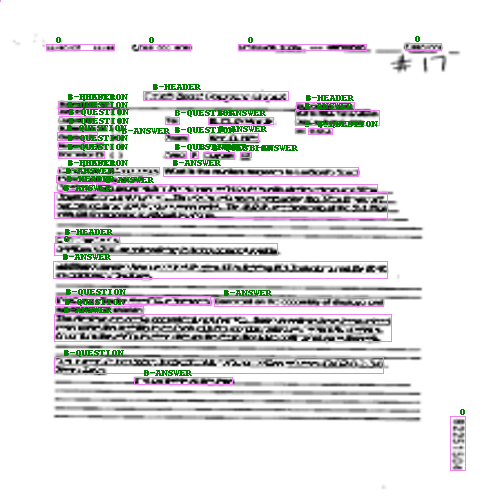

In [16]:
# Take the first sample from the evaluation dataset
sample = eval_dataset[3]

# Move the sample to the specified device
for key in sample.keys():
    sample[key] = sample[key].unsqueeze(0).to(device)

# Perform a forward pass on the model
with torch.no_grad():
    outputs = model(sample)

# Extract predictions from the model's output
predictions = outputs['logits'].argmax(-1)

# Find the position of the first padding token
pad_token_id = 0
for i, j in enumerate(sample["input_ids"][0]):
    if j == 1:
        pad_token_id = i
        break

# Extract predictions up to the position of the first padding token
predictions = predictions.squeeze(0)[:pad_token_id]
actual_prediction = [i.item() for i in predictions]

# Remove the added dimension from the sample
for key in sample.keys():
    sample[key] = sample[key].squeeze(0)

# Replace the original 'ner_tags' with the actual predictions
sample['ner_tags'] = actual_prediction

# Convert the pixel values to a PIL image and resize it
sample['image'] = ToPILImage()(sample.pop('pixel_values')).resize((500, 500))

# Remove the 'attention_mask' key and convert 'bbox' to a list
sample.pop("attention_mask")
sample['bboxes'] = sample.pop("bbox").tolist()

# Plot the visualization of the sample
plot_visualization(sample)


In [32]:
print('done')

done
